In [2]:
# Based from the tutorial of Jason Brownlee on Recurrent Neural Networks
%matplotlib inline  # allow Matplotlib plots to be displayed directly

from __future__ import print_function   # imports a feature from Python's future module that makes the print function compatible with both Python 2 and 3

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"  #sets environment variables for Theano, a deep learning library, to use GPU acceleration for faster computation.


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
# import necessary libraries: NumPy for numerical operations, Matplotlib for plotting, Pandas for data handling, and Math for mathematical functions

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
#import components from Keras, a popular deep learning framework, including Sequential model, Dense layer, LSTM layer, and MinMaxScaler from scikit-learn for data normalization.

plt.style.use('ggplot')
# sets the plotting style to the 'ggplot' style

In [3]:
# fix random seed for reproducibility
np.random.seed(10)

In [4]:
#Use the flood_data.csv dataset
dataframe = pandas.read_csv('dataset/flood_train.csv', usecols=[1], engine='python', skipfooter=3)
dataset   = dataframe.values #convert the Pandas DataFrame into a NumPy array and cast the data to float32 data type
dataset   = dataset.astype('float32')
dataframe.head()

,waterlevel
0,0.27
1,0.26
2,0.27
3,0.28
4,0.28


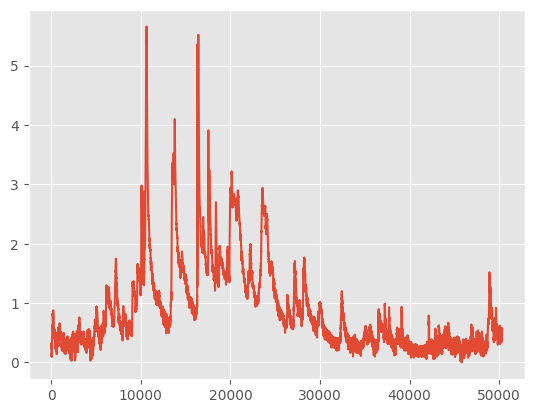

In [5]:
plt.plot(dataset)   #plots the loaded dataset

In [6]:
# normalize the dataset using Min-Max scaling to scale the values between 0 and 1.
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets
train_size  = int(len(dataset) * 0.67)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

33710 16604


----------------- TRAINING DATA -----------------


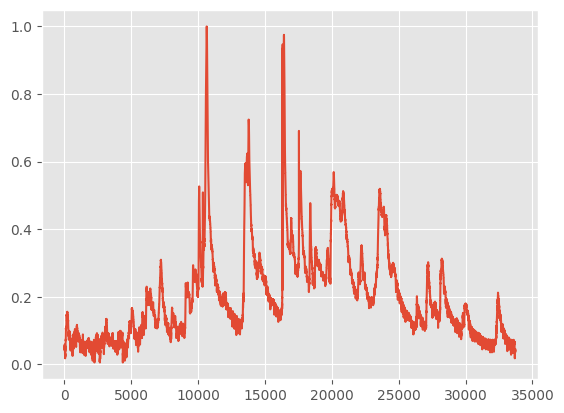

----------------- TEST DATA -----------------


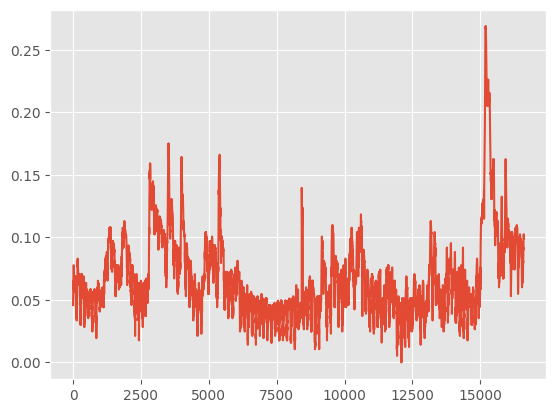

In [8]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

In [9]:
# This function creates a sliding window of the dataset.It takes a dataset and 
# creates input-output pairs for the LSTM model. Each input sequence has length sliding_window, and the corresponding output is the next value in the sequence.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
# generate the training and testing data sequences using the create_dataset function.
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [11]:
# reshape the data arrays to match the input shape expected by the LSTM model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=50, batch_size=1, verbose=2)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25712\1677430595.py", line 7, in <module>
    model.fit(trainX, trainY, nb_epoch=50, batch_size=1, verbose=2)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.fit() got an unexpected keyword argument 'nb_epoch'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fil

In [13]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.86 RMSE
Test Score: 0.27 RMSE


519/519 [==============================] - 1s 1ms/step


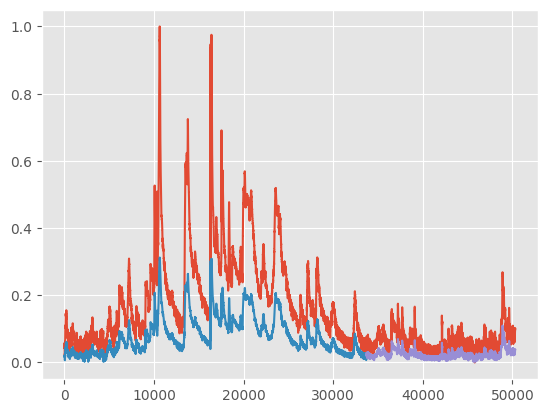

In [14]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict)+slide_window, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(slide_window*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

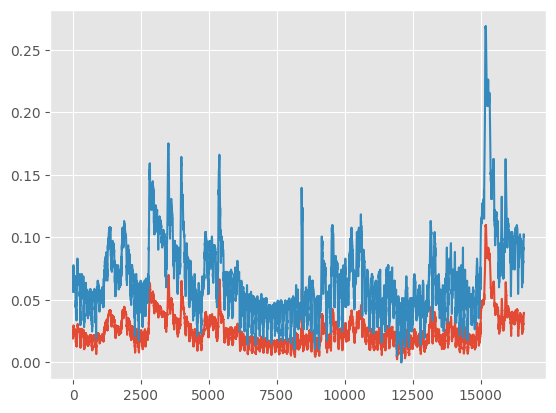

In [15]:
plt.plot(testPredict)
plt.plot(testY)

In [16]:
# Test the network on an unseen data
unseen = pandas.read_csv('dataset/flood_test.csv',sep=',')

In [17]:
unseen.head()

,datetime,rainfall,waterlevel
0,1/1/2013 0:10,0.0,0.21
1,1/1/2013 0:21,0.0,0.21
2,1/1/2013 0:30,0.0,0.40
3,1/1/2013 1:30,0.0,0.49
4,1/1/2013 1:40,0.0,0.59


In [18]:
unseen_test = unseen['waterlevel'].values

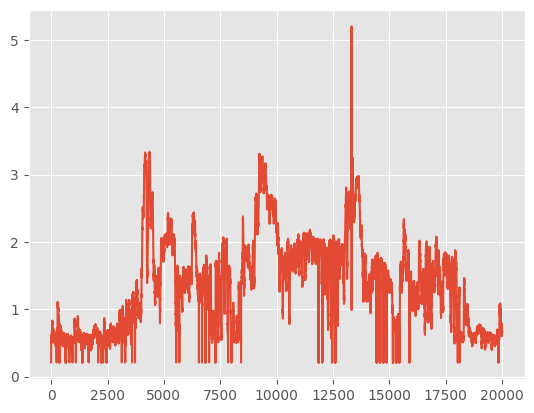

In [19]:
plt.plot(unseen_test[0:20000])

In [20]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

In [21]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, (109186,1, 10)) 

In [22]:
unseen_results = model.predict(features)

3413/3413 [==============================] - 5s 1ms/step


-------------------- Predicted --------------------


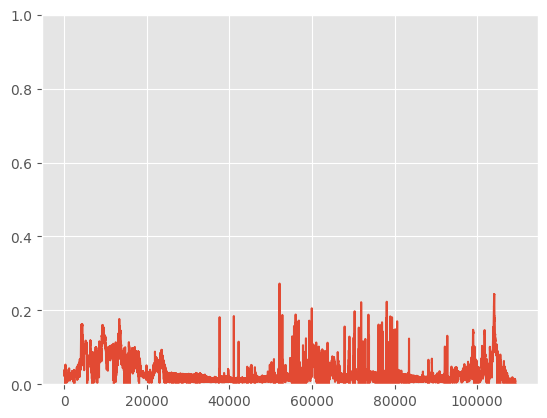

-------------------- Ground Truth --------------------


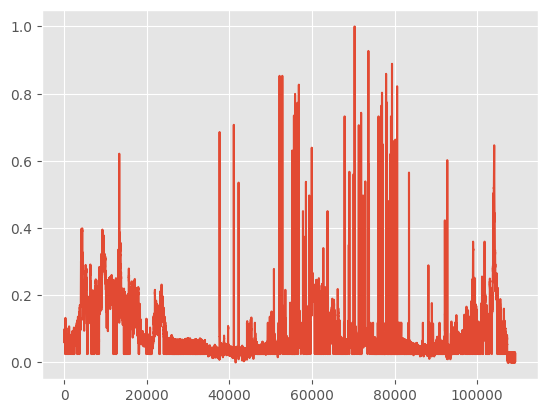

In [23]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(unseen_results)
plt.show()


print('-------------------- Ground Truth --------------------')
plt.plot(labels)
plt.show()

In [24]:
# Check the root mean squared error for the new test set

testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.59 RMSE


#### It seems that the network is having a hard time predicting higher flood level values
#### Checking the first 20000 data shows that the network is relatively comfortable on predicting ahead of time flood level values when the flood level  aren't extreme

----------------- Predicted ---------------


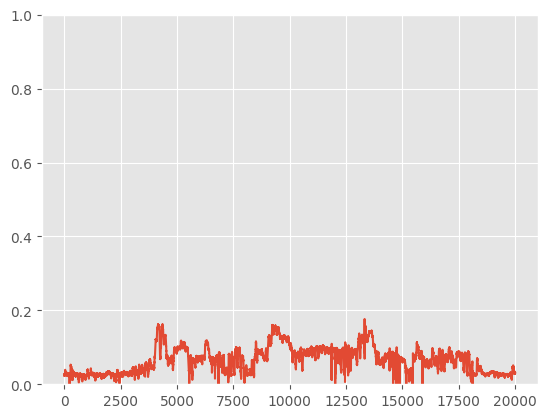

----------------- Ground Truth ---------------


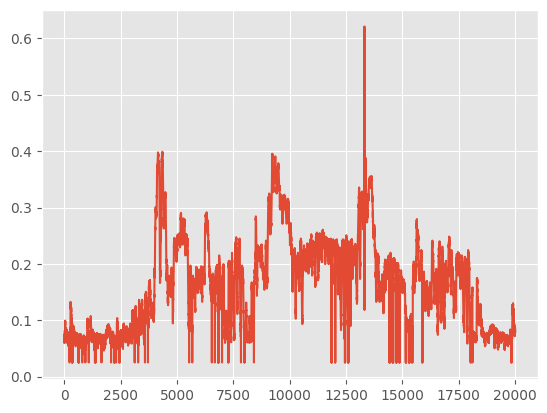

In [25]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('----------------- Predicted ---------------')
plt.plot(unseen_results[0:20000])
plt.show()

print('----------------- Ground Truth ---------------')
plt.plot(labels[0:20000])
plt.show()